## Actitracker labeled dataset NN model
This model will use keras to predict activity from sessionized accelerometer data, via the actitracker dataset (http://www.cis.fordham.edu/wisdm/dataset.php). 

### Data Processing

In [43]:
# Feature engineering 
import pandas as pd
import numpy as np
import scipy as sp

# Machine learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Charts
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Static params
DATA_FOLDER = 'Data/WISDM_ar_v1.1/'
DATA_FILE = 'raw_data_fixed.txt'

#### Data load

In [3]:
def load_data():
    global actitracker
    actitracker = pd.read_csv(
        DATA_FOLDER+DATA_FILE ,
        sep=',' ,
        lineterminator=';' ,
        header=None ,
    )
    actitracker.columns = [
        'user' ,
        'activity' ,
        'timestamp' ,
        'x-accel' ,
        'y-accel' ,
        'z-accel' ,
        'NA' ,
    ]
    del actitracker['NA']

#### Sessionize 

In [5]:
def create_sessions():
    global actitracker
    # re-calculate time in seconds
    actitracker['time_seconds'] = actitracker['timestamp']*10e-9

    # sort by user and time 
    actitracker = actitracker.sort_values(by=['user','time_seconds'])

    # create sessions
    session_length = 100
    actitracker['seq'] = xrange(actitracker.shape[0])
    actitracker['session'] = actitracker.\
                               groupby(['user','activity'])['seq'].\
                               apply(lambda x: x%session_length == 0).\
                               fillna(0).cumsum()

#### Gather labels

In [6]:
def gather_target_vars():
    global label_lookup
    # get session_labels 
    ohe = OneHotEncoder(sparse=False); le = LabelEncoder()
    labels = actitracker.groupby(['user','session'])['activity'].apply(lambda x: max(x))
    le_labels = le.fit_transform(labels)
    ohe_labels = ohe.fit_transform(le_labels.reshape(-1,1))
    label_lookup = { k: v for k,v in set((i, v) for i,v in np.vstack((le_labels,labels)).T) }
    
    # create target variables
    Y = pd.DataFrame(ohe_labels,index=labels.index)
    return Y

#### Calculate features 

In [7]:
def feature_engineering():
    # group by user and session
    accel_cols = ['x-accel','y-accel','z-accel']
    g = actitracker.loc[:,accel_cols+['user','session']].groupby(['user','session'])

    # IQR function
    def iqr(x):
        ''' calculate IQR from array
        '''
        q75, q25 = np.percentile(x, [75,25])
        return q75-q25

    # calculate model cols 
    means = g[accel_cols].apply(lambda x: np.mean(x))
    sds = g[accel_cols].apply(lambda x: np.std(x))
    median_1 = g[accel_cols[0]].apply(lambda x: np.median(x))
    median_2 = g[accel_cols[1]].apply(lambda x: np.median(x))
    median_3 = g[accel_cols[2]].apply(lambda x: np.median(x))
    iqr_1 = g[accel_cols[0]].apply(lambda x: iqr(x))
    iqr_2 = g[accel_cols[1]].apply(lambda x: iqr(x))
    iqr_3 = g[accel_cols[2]].apply(lambda x: iqr(x))
    mins = g[accel_cols].apply(lambda x: np.min(x))
    maxs = g[accel_cols].apply(lambda x: np.max(x))
    kurtosis_1 = g[accel_cols[0]].apply(lambda x: sp.stats.kurtosis(x))
    kurtosis_2 = g[accel_cols[1]].apply(lambda x: sp.stats.kurtosis(x))
    kurtosis_3 = g[accel_cols[2]].apply(lambda x: sp.stats.kurtosis(x))
    skew_1 = g[accel_cols[0]].apply(lambda x: sp.stats.skew(x))
    skew_2 = g[accel_cols[1]].apply(lambda x: sp.stats.skew(x))
    skew_3 = g[accel_cols[2]].apply(lambda x: sp.stats.skew(x))
    percentiles = []
    for i in range(10,100,10):
        for e in range(1,4):
            percentiles.append(eval('g[accel_cols['+str(e-1)+']].apply(lambda x: sp.percentile(x,'+str(i)+'))'))

    # concat columns
    X = pd.concat([means,
                   sds,
                   median_1,
                   median_2,
                   median_3,
                   iqr_1,
                   iqr_2,
                   iqr_3,
                   mins,
                   maxs,
                   kurtosis_1,
                   kurtosis_2,
                   kurtosis_3,
                   skew_1,
                   skew_2,
                   skew_3,
                  ]+percentiles
                  ,axis=1)

    # Scale data
    ss = StandardScaler()
    X = ss.fit_transform(X)
    return X

#### Split test and train

In [102]:
load_data()
create_sessions()
Y = gather_target_vars()
X = feature_engineering()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.as_matrix(), test_size=0.33, random_state=22)

### Baseline LR Model

In [103]:
class ActitrackerLR:
    ''' Logistic Regression models
        one for each class
    '''
    @staticmethod
    def train_models(X_train, Y_train, model_params):
        ''' Train models iteratively 
            for each class
        '''
        models = [] 
        for i in xrange(Y_train.shape[1]):
            model = LogisticRegression(**model_params)
            y = Y_train[:,i]
            model.fit(X_train, y)
            models.append(model)
        return models
    
    @staticmethod
    def make_predictions(X_test, models, num_classes=6):
        ''' Make predictions 
            for each class 
        '''
        predictions = np.zeros((X_test.shape[0], num_classes))
        for i, model in enumerate(models):
            p = model.predict_proba(X_test)
            predictions[:,i] = p[:,1]
        return predictions

lrmodel = ActitrackerLR()

#### Evaluate model params

In [105]:
c_values = [ 1e-5, 1e-3, 1e-1, 1.0, 10.0, 1e2, 1e4, 1e6 ]
def lr_evaluate_params(c_values):
    accuracies = []
    log_losses = []
    for c in c_values:
        params = {'C':c,'max_iter':1000,'tol':1e-8}
        models = lrmodel.train_models(X_train, Y_train, params)
        predictions = lrmodel.make_predictions(X_test, models, 6)
        accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(predictions,axis=1))
        ll = log_loss(Y_test, predictions)
        accuracies.append(accuracy)
        log_losses.append(ll)
    evaluation = pd.DataFrame({'C':c_values,'accuracy':accuracies,'log_loss':log_losses})
    print evaluation
    return evaluation

evaluation = lr_evaluate_params(c_values)

               C  accuracy  log_loss
0        0.00001  0.683443  1.710534
1        0.00100  0.732673  1.120656
2        0.10000  0.823432  0.573227
3        1.00000  0.838284  0.529065
4       10.00000  0.841309  0.524394
5      100.00000  0.841309  0.529344
6    10000.00000  0.841309  0.540622
7  1000000.00000  0.841309  0.541216


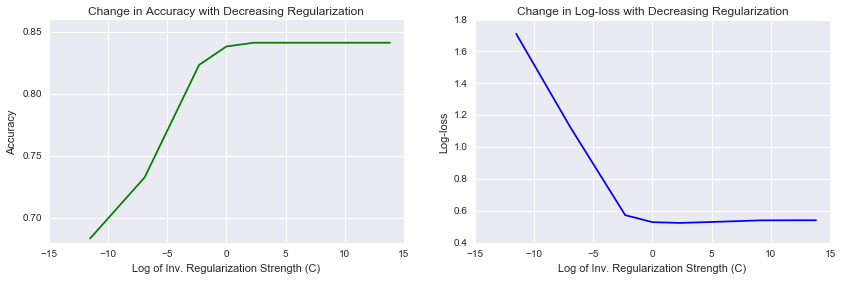

In [106]:
def lr_param_charts(c_values, accuracies, log_losses):
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.plot(np.log(c_values), accuracies, 'g')
    plt.title("Change in Accuracy with Decreasing Regularization")
    plt.xlabel("Log of Inv. Regularization Strength (C)")
    plt.ylabel("Accuracy")
    plt.subplot(1,2,2)
    plt.plot(np.log(c_values), log_losses, 'b')
    plt.title("Change in Log-loss with Decreasing Regularization")
    plt.xlabel("Log of Inv. Regularization Strength (C)")
    plt.ylabel("Log-loss")

lr_param_charts(evaluation['C'],evaluation['accuracy'],evaluation['log_loss'])

#### Train final model

In [107]:
params = {'C':10.0,'max_iter':1000,'tol':1e-8,'solver':'lbfgs'}
models = lrmodel.train_models(X_train, Y_train, params)

#### Test prediction accuracy

In [108]:
def print_accuracy(true_category, pred_category):
    print 'Accuracy: {}'.format(accuracy_score(true_category, pred_category ))
    print 'Log-loss: {}'.format(log_loss(Y_test, predictions))

In [109]:
predictions = lrmodel.make_predictions(X_test, models, 6)
pred_category = np.argmax(predictions, axis=1)
true_category = np.argmax(Y_test, axis=1)

In [110]:
print_accuracy(true_category, pred_category)

Accuracy: 0.841309130913
Log-loss: 0.524565689825


#### Analyze errors

In [111]:
get_label = np.vectorize(lambda x: label_lookup[x])
    
def analyze_errors(true_category, pred_category, get_label=get_label):
    errors = pred_category != true_category
    true_labels = get_label(true_category)
    base = np.ones(true_labels.shape)
    error_base = pd.DataFrame({'errors':errors,
                      'labels':true_labels,
                      'base':base})
    b = error_base.groupby('labels').sum()
    error_rates = pd.DataFrame((b['errors']/b['base']).sort_values(ascending=False), columns=['Error Rate'])
    error_rates['Total Session Counts'] = b['base']
    return error_rates

In [112]:
analyze_errors(true_category, pred_category)

,Error Rate,Total Session Counts
labels,,
Upstairs,0.536866,434.0
Downstairs,0.479730,296.0
Sitting,0.113990,193.0
Standing,0.090909,154.0
Walking,0.088050,1431.0
Jogging,0.035461,1128.0


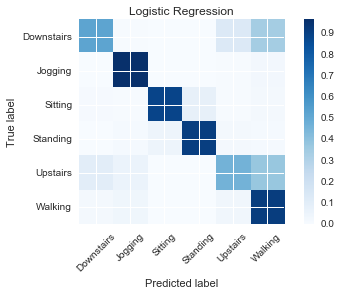

In [113]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    classes = label_lookup.values()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Logistic Regression')

### MLP Neural Network Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using Theano backend.


#### Compile model

In [ ]:
model = Sequential()

indim = X.shape[1]
model.add(Dense(512*4, input_dim=indim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#### Execute model

In [ ]:
model.fit(X_train, Y_train,
          nb_epoch=20,
          batch_size=20)

In [35]:
predictions = model.predict(X_test)
pred_category = np.argmax(predictions, axis=1)
true_category = np.argmax(Y_test, axis=1)
print_accuracy(true_category, pred_category)

Accuracy: 0.911716171617
Log-loss: 0.282118099038


In [ ]:
analyze_errors(true_category, pred_category)

<table border=1 class="dataframe" align="left">
<thead>
 <tr style=text-align: left;>
   <th></th>
   <th>Error Rate</th>
   <th>Total Session Counts</th>
 </tr>
 <tr>
   <th>labels</th>
   <th></th>
   <th></th>
 </tr>
</thead>
<tbody>
 <tr>
   <th>Upstairs</th>
   <td>0.299539</td>
   <td>434.0</td>
 </tr>
 <tr>
   <th>Downstairs</th>
   <td>0.277027</td>
   <td>296.0</td>
 </tr>
 <tr>
   <th>Sitting</th>
   <td>0.067358</td>
   <td>193.0</td>
 </tr>
 <tr>
   <th>Standing</th>
   <td>0.058442</td>
   <td>154.0</td>
 </tr>
 <tr>
   <th>Walking</th>
   <td>0.046820</td>
   <td>1431.0</td>
 </tr>
 <tr>
   <th>Jogging</th>
   <td>0.023936</td>
   <td>1128.0</td>
 </tr>
</tbody>
</table>

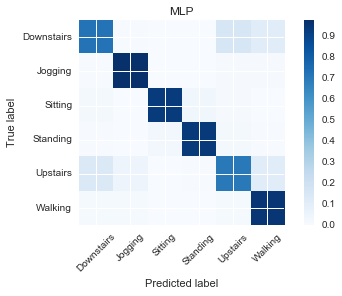

In [100]:
cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'MLP')

### XGA Boost 

In [78]:
import xgboost as xgb

#### Compile model

In [ ]:
dtrain = xgb.DMatrix( X_train, label=np.argmax(Y_train, axis=1))
dtest = xgb.DMatrix( X_test, label=np.argmax(Y_test, axis=1))
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'bst:max_depth':6, 
         'bst:eta':1, 
         'subsample':0.5, 
         'silent':1, 
         'num_class':6,
         'objective':'multi:softprob' }
param['eval_metric'] = 'mlogloss'
model = xgb.train(param.items(), dtrain, 100, evallist)

#### Test accuracy

In [117]:
predictions = model.predict(dtest)
pred_category = np.argmax(predictions, axis=1)
true_category = np.argmax(Y_test, axis=1)
print_accuracy(true_category, pred_category)

Accuracy: 0.932068206821
Log-loss: 0.278720681422


#### Analyze errors

In [118]:
analyze_errors(true_category, pred_category)

,Error Rate,Total Session Counts
labels,,
Downstairs,0.256757,296.0
Upstairs,0.175115,434.0
Standing,0.051948,154.0
Sitting,0.046632,193.0
Walking,0.042628,1431.0
Jogging,0.015071,1128.0


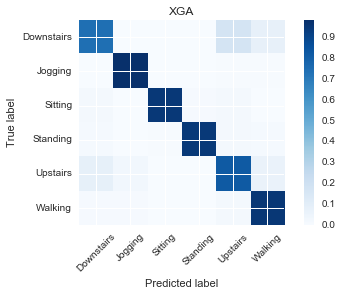

In [119]:
cm = confusion_matrix(true_category, pred_category)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'XGA')

### RNN

In [8]:
from keras.layers.core import Flatten
from keras.layers.recurrent import GRU

Using Theano backend.


In [18]:
session_length = 100
nnum = (actitracker.shape[0]//session_length)
lim = nnum * session_length
X = actitracker.iloc[:lim,:][['x-accel','y-accel','z-accel']].as_matrix()
Y = actitracker.iloc[:lim,:].groupby(['session'])['activity'].apply(lambda x: max(x))
ohe = OneHotEncoder(sparse=False); le = LabelEncoder()
Y = ohe.fit_transform(le.fit_transform(Y.iloc[:lim]).reshape(-1,1))
X = X[:lim].T.reshape((nnum, session_length, 3))

In [ ]:
model = Sequential()
model.add(GRU(32, return_sequences=True, input_dim=3, input_length=session_length, dropout_W=.5, dropout_U=.5))
model.add(GRU(32, return_sequences=True, dropout_W=.5, dropout_U=.5))
model.add(GRU(32, dropout_W=.5, dropout_U=.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
indices = np.random.permutation(nnum)
train, test = indices[:(nnum//3)*2], indices[(nnum//3)*2:]

In [ ]:
model.fit(X[train], Y[train],
          nb_epoch=20,
          batch_size=20)

In [ ]:
predictions = model.predict(X[test])
print 'Accuracy: {}'.format(accuracy_score(np.argmax(Y[test], axis=1), np.argmax(predictions,axis=1)) )
print 'Log-loss: {}'.format(log_loss(Y[test], predictions))